# Example
A simple tutorial on how to use functions

In [1]:
import sys
import os

# Proje dizinini Python path'e ekle
project_root = os.path.abspath("..")  # Eğer examples klasöründeysen
sys.path.insert(0, project_root)


In [2]:
from sdss_fetch import (
    SDSSParallelDownloader,
    CutoutFetcher,
    SpectrumPreview,
    TargetResolver,
    MetadataExtractor,
    PhotometryFetcher
)

import pandas as pd

In [3]:
data = {
    "ra": [207.617395],
    "dec": [23.893125]
}
targets = pd.DataFrame(data)


In [4]:
resolver = TargetResolver(radius_arcsec=30.0, data_release=16)
resolved = resolver.resolve_all(targets, select=0)
resolved



[Match list for RA=207.617395, DEC=23.893125]
   plate    mjd  fiberID            specobjid          ra        dec
0   6001  56072      858  6756761288079331328  207.617396  23.893125

→ Selected row: 0
plate                       6001
mjd                        56072
fiberID                      858
specobjid    6756761288079331328
ra                    207.617396
dec                    23.893125


,plate,mjd,fiberID,specobjid,ra,dec
0,6001,56072,858,6756761288079331328,207.617396,23.893125


In [5]:
downloader = SDSSParallelDownloader(output_dir="spectra", max_workers=4)
downloader.download_all(
    plates=resolved["plate"].tolist(),
    mjds=resolved["mjd"].tolist(),
    fibers=resolved["fiberID"].tolist(),
    verbose=True
)


[1] Starting download...
[1] ✓ spec-6001-56072-0858.fits


[2025-05-02 07:02:50] Coordinates set to RA=207.617395, DEC=23.893125
[2025-05-02 07:02:53] Saved cutout: cutouts/image-ra207.6174-dec23.8931.png
[2025-05-02 07:02:53] → Download URL: http://skyserver.sdss.org/dr16/SkyServerWS/ImgCutout/getjpeg?TaskName=Skyserver.Chart.Image&ra=207.617395&dec=23.893125&scale=0.2&width=512&height=512&opt=SLG&query=&SpecObjs=on&Label=on&Grid=on
[2025-05-02 07:02:53] → RA=207.617395, DEC=23.893125, scale=0.2, size=512, opt='SLG'


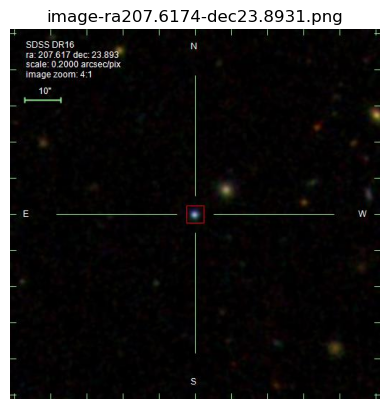

In [6]:
cutout = CutoutFetcher(
    output_dir="cutouts",
    scale=0.2,
    size=512,
    opt="SLG",
)
cutout.fetch_all(targets)

In [7]:
cutout.fetch_fits_image(band="u")


[2025-05-02 07:02:54] Saved FITS image: fits_images/fits-bandu-ra207.6174-dec23.8931.fits


'fits_images/fits-bandu-ra207.6174-dec23.8931.fits'

In [8]:
photo = PhotometryFetcher()
df = photo.fetch_all(targets)
df

#photo.save_to_csv(df, "photometry.csv")

#photo.save_to_fits(df, "photometry.fits")


[2025-05-02 07:02:54] Found 2 photo objects near RA=207.617395, DEC=23.893125


,ra,dec,objid,u,g,r,i,z
0,207.617403,23.893129,1237667912212873373,20.04623,19.44410,19.39359,19.34162,19.18173
1,207.617396,23.893125,1237667912212873374,20.04553,19.44891,19.40163,19.35509,19.19865


SpectrumPreview?

[2025-05-02 07:02:56] Saved preview: previews/spec-6756761288079331328.png


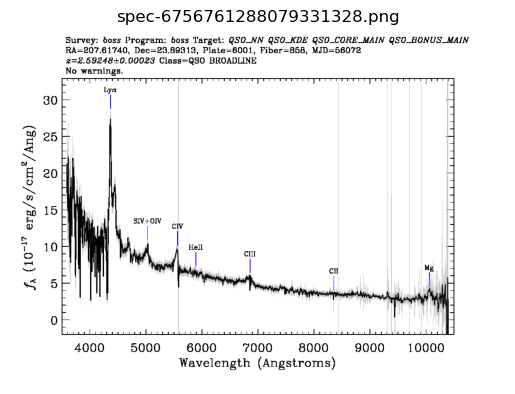

In [9]:
preview = SpectrumPreview(output_dir="previews", retry_wait=60)
preview.fetch_all(resolved)


In [10]:
import os
fits_files = [os.path.join("spectra", f) for f in os.listdir("spectra") if f.endswith(".fits")]
extractor = MetadataExtractor()
meta_df = extractor.extract_metadata(fits_files)
meta_df

,filename,plate,mjd,fiberID,z,z_err,class,subclass,snr,specobjid
0,spec-6001-56072-0858.fits,6001,56072,858,2.59248,0.000226,QSO,BROADLINE,12.829926,6756761288079331328


In [11]:
lines_df = extractor.summarize_lines(fits_files[0])
print(lines_df)


        linename     linewave        sigma        flux        snr
0  Ly_alpha       1215.670000  1091.934937  621.143677  44.829769
1  N_V 1240       1240.810000  2317.856689  695.066223  36.543125
2  C_IV 1549      1549.480000  1510.182983  160.968369  17.262163
3  C_III] 1908    1908.734000  1510.182983   56.391754   9.128559
4  Mg_II 2799     2800.315189  1510.182983   62.590584   3.206078


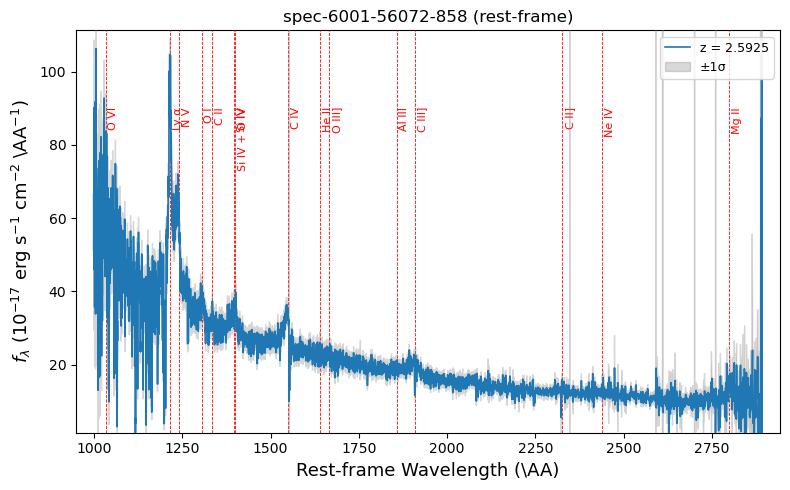

In [12]:
#%matplotlib widget
extractor.plot_restframe(fits_files[0], show_lines=True)
